In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf

In [2]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
data_path = "H:\\AICUP\\trainset_800"
os.path.exists(data_path)

True

In [4]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path):
    if root.split("\\")[-1]!="model-logs":
      for file in files:
        if file.find("checkpoint")==-1:
          if file[-3:]=="csv":
            #class_path = os.path.join(root, file)
            class_path=root+"\\"+file
          else:
            #img_list.append(os.path.join(root, file))
            img_list.append(root+"\\"+file)
            label = root.split("\\")[-1]
            types = root.split("\\")[-2]
            data_label.append(label)
            data_types.append(types)
  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
    print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [5]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'asparagus': '0', 'bambooshoots': '1', 'betel': '2', 'broccoli': '3', 'cauliflower': '4', 'chinesecabbage': '5', 'chinesechives': '6', 'custardapple': '7', 'grape': '8', 'greenhouse': '9', 'greenonion': '10', 'kale': '11', 'lemon': '12', 'lettuce': '13', 'litchi': '14', 'longan': '15', 'loofah': '16', 'mango': '17', 'onion': '18', 'others': '19', 'papaya': '20', 'passionfruit': '21', 'pear': '22', 'pennisetum': '23', 'redbeans': '24', 'roseapple': '25', 'sesbania': '26', 'soybeans': '27', 'sunhemp': '28', 'sweetpotato': '29', 'taro': '30', 'tea': '31', 'waterbamboo': '32'}


In [6]:
train_list

,img_path,label_name,label
8952,H:\AICUP\trainset_800\train\asparagus\000b43a3...,asparagus,0
8953,H:\AICUP\trainset_800\train\asparagus\00172189...,asparagus,0
8954,H:\AICUP\trainset_800\train\asparagus\002aec7b...,asparagus,0
8955,H:\AICUP\trainset_800\train\asparagus\007cd63a...,asparagus,0
8956,H:\AICUP\trainset_800\train\asparagus\00a326ba...,asparagus,0
...,...,...,...
80558,H:\AICUP\trainset_800\train\waterbamboo\ffb5fc...,waterbamboo,32
80559,H:\AICUP\trainset_800\train\waterbamboo\ffd756...,waterbamboo,32
80560,H:\AICUP\trainset_800\train\waterbamboo\ffd9c5...,waterbamboo,32
80561,H:\AICUP\trainset_800\train\waterbamboo\fff0cf...,waterbamboo,32


In [7]:
# class_map={'asparagus':0,'bambooshoots':1,'betel':2,'broccoli':3,'cauliflower':4,'chinesecabbage':5,'chinesechives':6,
#                'custardapple':7,'grape':8,'greenhouse':9,'greenonion':10,'kale':11,'lemon':12,'lettuce':13,'litchi':14,
#                'longan':15,'loofah':16,'mango':17,'onion':18,'others':19,'papaya':20,'passionfruit':21,'pear':22,
#                'pennisetum':23,'redbeans':24,'roseapple':25,'sesbania':26,'soybeans':27,'sunhemp':28,'sweetpotato':29,
#                'taro':30,'tea':31,'waterbamboo':32}
class_map_new={'others':0,'nonothers':1}

In [8]:
#extract classes from 0 class
# train_list_new=train_list[train_list["label"]==0]
# valid_list_new=valid_list[valid_list['label']==0]
# test_list_new=test_list[test_list['label']==0]
# for i in range(17):
#     label=str(i)
#     t=train_list[train_list["label"]==label]
#     train_list_new=pd.concat([train_list_new,t])
#     v=valid_list[valid_list["label"]==label]
#     valid_list_new=pd.concat([valid_list_new,v])
#     test=test_list[test_list["label"]==label]
#     test_list_new=pd.concat([test_list_new,test])
# print(train_list_new)
# print(valid_list_new)
# print(test_list_new)

In [9]:
#extract specific classes
train_list_new=train_list[train_list["label"]=='1']
train_list_new=pd.concat([train_list_new,train_list[train_list["label"]=='2']])
valid_list_new=valid_list[valid_list['label']=='1']
valid_list_new=pd.concat([valid_list_new,valid_list[valid_list["label"]=='2']])
test_list_new=test_list[test_list['label']=='1']
test_list_new=pd.concat([test_list_new,test_list[test_list["label"]=='2']])

train_list_new=train_list_new.replace(["1","2"],['0','1'])
valid_list_new=valid_list_new.replace(["1","2"],['0','1'])
test_list_new=test_list_new.replace(["1","2"],['0','1'])

In [10]:
class_map_new.keys()
#class_map.keys()

dict_keys(['bambooshoots', 'betel'])

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [12]:
#num_classes = train_list_new["label"].unique().shape[0]
num_classes = train_list_new["label"].unique().shape[0]
num_classes

2

In [30]:
img_shape = (400,400)
batch_size = 8

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
from tensorflow.keras.applications.xception import Xception,preprocess_input

In [33]:
def HSV(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv_image=tf.image.adjust_saturation(hsv_image,0.5)#飽和度
    hsv_image=tf.image.adjust_brightness(hsv_image,0.5)#亮度
    return Image.fromarray(np.uint8(hsv_image))

In [34]:
train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.2,
                    brightness_range=(1,3),
                    preprocessing_function=preprocess_input
                    )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [35]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

Found 5108 validated image filenames belonging to 2 classes.
Found 638 validated image filenames belonging to 2 classes.
Found 639 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 400, 400, 3)
(400, 400, 3) 1.0 -1.0


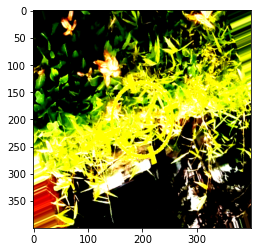

In [36]:
(data_train,label_train)= train_generator.next()
print(data_train.shape)
img=data_train[-1,:,:,:]
img=img
print(img.shape,img.max(),img.min())
plt.imshow(img)

In [37]:
pre_model = Xception(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

x = layers.AveragePooling2D()(pre_model.output)
x=layers.Flatten()(x)
# x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

In [38]:
model = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [39]:
def lr_schedule(epoch):
    lrate=0.001
    if epoch>10:
        lrate=0.0005
    if epoch>15:
        lrate=0.0003
    if epoch>20:
        lrate=0.0001
    return lrate

In [40]:
import tensorflow as tf

model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model-test000.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)
reduce_lr=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                      patience=10,min_lr=0.001,
                                      verbose=0,mode='auto',
                                      min_delta=0.001,cooldown=0)
import datetime
logdir=os.path.join(data_path,'logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir,
                                                    histogram_freq=1,
                                                    write_images=True,
                                                    embeddings_freq=1)

lrschedule=tf.keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks_list = [model_mckp,lrschedule]

In [41]:
def num_steps_per_epoch(data_generator, batch_size):
  if data_generator.n % batch_size==0:
    return data_generator.n//batch_size
  else:
    return data_generator.n//batch_size + 1

In [42]:
lr = 1e-3
batch_size = 8
num_epochs = 20

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [43]:
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 199, 199, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 199, 199, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 50, 50, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 50, 50, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 50, 50, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 50, 50, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 25, 25, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 25, 25, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 25, 25, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 25, 25, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 25, 25, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 25, 25, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 25, 25, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 25, 25, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 25, 25, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 25, 25, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [45]:
pre_model.trainable = False

In [46]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

Epoch 1/20
639/639 [==============================] - 353s 548ms/step - loss: 0.7129 - accuracy: 0.5687 - val_loss: 0.7395 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 2/20
639/639 [==============================] - 323s 505ms/step - loss: 0.6640 - accuracy: 0.6094 - val_loss: 0.6624 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 3/20
639/639 [==============================] - 294s 460ms/step - loss: 0.6160 - accuracy: 0.6729 - val_loss: 0.8289 - val_accuracy: 0.6285 - lr: 0.0010
Epoch 4/20
639/639 [==============================] - 296s 462ms/step - loss: 0.5756 - accuracy: 0.7044 - val_loss: 2.7910 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 5/20
639/639 [==============================] - 294s 459ms/step - loss: 0.5670 - accuracy: 0.7152 - val_loss: 0.8605 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 6/20
639/639 [==============================] - 317s 496ms/step - loss: 0.5539 - accuracy: 0.7234 - val_loss: 0.6278 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 7/20
639/639 [==========================

In [47]:
pre_model.trainable = True
for each_layer in pre_model.layers[:-5]: #倒數五層
    each_layer.trainable = False

batch_size = 8
num_epochs = 30

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [48]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list,
                  initial_epoch=20)

Epoch 21/30
639/639 [==============================] - 307s 479ms/step - loss: 0.3926 - accuracy: 0.8177 - val_loss: 0.4299 - val_accuracy: 0.8025 - lr: 3.0000e-04
Epoch 22/30
639/639 [==============================] - 316s 494ms/step - loss: 0.3692 - accuracy: 0.8277 - val_loss: 0.4399 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 23/30
639/639 [==============================] - 298s 466ms/step - loss: 0.3552 - accuracy: 0.8375 - val_loss: 0.4400 - val_accuracy: 0.8072 - lr: 1.0000e-04
Epoch 24/30
639/639 [==============================] - 322s 504ms/step - loss: 0.3642 - accuracy: 0.8310 - val_loss: 0.4132 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 25/30
639/639 [==============================] - 324s 506ms/step - loss: 0.3550 - accuracy: 0.8412 - val_loss: 0.4213 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 26/30
639/639 [==============================] - 288s 450ms/step - loss: 0.3499 - accuracy: 0.8434 - val_loss: 0.4415 - val_accuracy: 0.7962 - lr: 1.0000e-04
Epoch 27/30
639/

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [50]:
from keras.models import model_from_json
import keras

In [ ]:
model.save('F:\\AICUP\\trainset_400\\model-logs\\broccoli_cauliflower(0.791).h5')

In [ ]:
# model=keras.models.load_model('F:\\AICUP\\trainset_400\\model-logs\\broccoli_cauliflower.h5')
# model.summary()

In [51]:
batch_size = 8
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [52]:
y_test = test_list_new["label"].values.astype(np.int_)#need to be changed
#y_test=np.transpose(test_generator.labels)

In [53]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
y_test_predprob = model.predict(test_generator,verbose=1)
y_test_pred = y_test_predprob.argmax(-1)

80/80 [==============================] - 18s 219ms/step


In [55]:
y_test_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score: 0.809


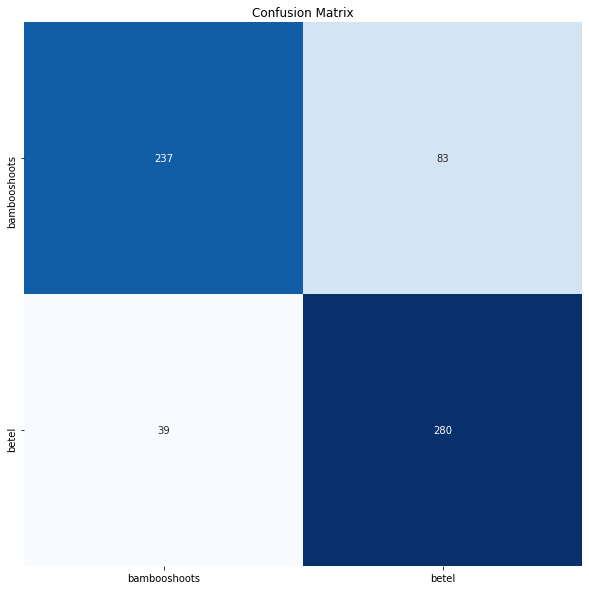

In [57]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map_new.keys(), yticklabels=class_map_new.keys())
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 畫圖 train/test Accuracy plot
history.history.keys()
# # train/valid Plot
import matplotlib.pyplot as plt
plt.title('Accuracy of train and test')
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [ ]:
# 畫圖 train/test Loss/cost plot
plt.title('Loss of train and test')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
#F1-score
from  sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

# Upload from df

In [ ]:
look_up = { 0:'asparagus', 1:'bambooshoots', 2:'betel', 3:'broccoli', 4:'cauliflower', 
         5:'chinesecabbage', 6:'chinesechives', 7:'custardapple', 8:'grape', 9:'greenhouse', 
         10:'greenonion', 11:'kale', 12:'lemon', 13:'lettuce', 14:'litchi', 15:'longan', 
         16:'loofah', 17:'mango', 18:'onion', 19:'others', 20:'papaya', 21:'passionfruit', 
         22:'pear', 23:'pennisetum', 24:'redbeans', 25:'roseapple', 26:'sesbania', 27:'soybeans', 
         28:'sunhemp', 29:'sweetpotato', 30:'taro', 31:'tea', 32:'waterbamboo'}

In [ ]:
from glob import glob
img_shape=(256,256)
jpglist = glob('F:\\AICUP\\public_400\\*.[jJ][pP][gG]')#把路徑下的所有圖片名稱變成一個列表
jpglist

In [ ]:
#predict from df
testdf = pd.DataFrame({"img_path":jpglist})
testdf

In [ ]:
batch_size = 16
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
#predict from df
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=testdf,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

In [ ]:
#predict from df
y_test_predprob = model.predict(test_generator,verbose=1)
y_test_pred = y_test_predprob.argmax(-1)
y_test_pred

In [ ]:
#predict from df
pred_label=list()
for i in range(len(y_test_pred)):
    pred_label.append(y_test_pred[i])

In [ ]:
#predict from df
filelist=list()
for file in jpglist:
    file=file.split('\\')[-1]
    print(file)
    filelist.append(file)

In [ ]:
#predict from df
import pandas as pd
submit = pd.DataFrame(filelist,columns=['filename'])
submit

In [ ]:
#predict from df
submit['label'] = pd.DataFrame(pred_label)
submit['label'] = submit['label'].map(look_up)
submit

In [ ]:
#predict from df
submit.to_csv('F:\\AICUP\\upload\\submission66.csv',index=False)# index=False去掉索引

# Upload from single img

In [ ]:
#predict from single img
pred_label=list()

for jpg in jpglist:
    img_path=jpg
    # preprocess image
    image = tf.keras.preprocessing.image.load_img( img_path, target_size=img_shape)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = preprocess_input( np.array([input_arr]) ) # Convert single image to a batch.

    # predict on image
    predictions = model.predict(input_arr).argmax()
    print(predictions)
    pred_label.append(predictions)

In [ ]:
#predict from single img
filelist=list()
for file in jpglist:
    file=file.split('\\')[-1]
    print(file)
    filelist.append(file)

In [ ]:
#predict from single img
import pandas as pd
submit = pd.DataFrame(filelist,columns=['filename'])
submit

In [ ]:
#predict from single img
submit['label'] = pd.DataFrame(pred_label)
submit['label'] = submit['label'].map(look_up)
submit

In [ ]:
#predict from single img
submit.to_csv('F:\\AICUP\\upload\\submission643.csv',index=False)# index=False去掉索引

# Grad Cam

In [ ]:
#model.save('D:\\AICUP\\trainset_400\\model-logs\\xception(0.607).h5')
#model=keras.models.load_model('D:\\AICUP\\trainset_400\\model-logs\\basic_model-best-model-test000.h5')

In [ ]:
#compare the differences between y_test_pred and y_test
index=0
wrong_index=list()
for i in range(len(y_test)):
    if y_test[i]!=y_test_pred[i]:
        wrong_index.append(index)
    index+=1
print(wrong_index)
print(len(wrong_index))

In [ ]:
wrong_img=list()
for i in wrong_index:
    wrong_img.append(test_list_new.iloc[i].img_path)
len(wrong_img)

In [ ]:
wrong_img_label=list()
for i in wrong_index:
    wrong_img_label.append(test_list_new.iloc[i].label)
len(wrong_img_label)

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
#讀取影像並縮放為模型input的大小
def show_gradcam(IMG_PATH,LAYER_NAME,CLASS_INDEX):

    img = tf.keras.preprocessing.image.load_img( IMG_PATH, target_size=img_shape )
    img = tf.keras.preprocessing.image.img_to_array(img)

    img = np.array([img])  # Convert single image to a batch.

    #把影像進行對應的前處理
    img = preprocess_input(img)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), img_shape)
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image = cv2.addWeighted(cv2.cvtColor(img[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    #cv2.imwrite('cam.png', output_image)

    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    return plt.imshow(output_image)

In [ ]:
def predict_one(img_size,img_path,model_path):
    # load model
    model = keras.models.load_model(model_path)

    # preprocess image
    image = tf.keras.preprocessing.image.load_img( img_path, target_size=(img_size, img_size))
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = preprocess_input( np.array([input_arr]) ) # Convert single image to a batch.

    # predict on image
    predictions = model.predict(input_arr)
    return predictions.argmax()

In [ ]:
def show_result(img_size,img_path,model_path,LAYER_NAME,CLASS_INDEX):
    result=predict_one(img_size,img_path,model_path)
    print(CLASS_INDEX,'--->',result)
    show_gradcam(img_path,LAYER_NAME,CLASS_INDEX)

In [ ]:
img_shape=(400,400)
model_path = 'F:\\AICUP\\trainset_400\\model-logs\\broccoli_cauliflower.h5'
LAYER_NAME = 'block14_sepconv2_act' 

index=25 #change index to show different image
img_path=wrong_img[index]
plt.subplot(1,2,1)
img=Image.open(img_path)
plt.title(img_path)
plt.imshow(img)
plt.subplot(1,2,2)
CLASS_INDEX =int(wrong_img_label[index])
show_result(img_size,img_path,model_path,LAYER_NAME,CLASS_INDEX)